In [1]:
import pandas as pd
import numpy as np
import pyodbc
import sklearn as sk
import tensorflow as tf
import json

In [2]:
# Setup SQL
global con, cur
with open(r"sql_config.json") as f:
    sql_config = json.load(f)
con = pyodbc.connect(
    "Driver={SQL Server Native Client 11.0};"
    f"Server={sql_config['ip']},{sql_config['port']};"
    f"Database={sql_config['database']};"
    f"UID={sql_config['uid']};"
    f"PWD={sql_config['password']}"
)
cur = con.cursor()

In [3]:
# Pull all data from FatTrimmerData into df
df = pd.DataFrame()
sql = "SELECT * FROM FatTrimmerData;"
for chunk in pd.read_sql(sql, con, chunksize=10000):
    df = pd.concat([df, chunk])

c:\Users\qsiba\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
# Remove any rows where DeltaTime is -1
df = df[df.DeltaTime != -1]
# Drop any duplicate rows incase scraping makes a mistake
#df.drop_duplicates(inplace=True)
# Convert NewItems bool -> int
df["NewItems"] = df["NewItems"].astype(int)

In [5]:
# Create independent variables
df.drop_duplicates()
df.drop(columns=["Batch"])
x = df.drop(columns=["NewItems"])
# Create dependent variables
y = df["NewItems"]

In [6]:
df.head(10)

,NewItems,PageNumber,DeltaTime,Batch
0,0,0,4503000,3128
1,0,0,3964000,3710
2,0,0,5244000,6117
3,0,0,2366000,6242
4,0,0,6794000,8876
5,1,0,2851000,10173
6,0,0,3491000,11165
7,1,0,9222000,14098
8,0,0,3330000,15156
9,0,0,1684000,16111


In [7]:
# How many gpus can tensorflow see
print(f"num physical devices: {len(tf.config.list_physical_devices('GPU'))}")

num physical devices: 1


In [8]:
from sklearn.model_selection import train_test_split
# Split data into training and testing (80-20 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Dropout

# Crate a sequential model with 3 layers, each layer is named after an anime waifu
# Units describe the dimensionality of the layer output
# Activation is the function responsible for computing the output of the node
# TODO describe input shape bs
neg,pos = np.bincount(df['NewItems'])
print(pos)
print(neg)
initial_bias = np.log([pos/neg])
#
output_bias = tf.keras.initializers.Constant(initial_bias)
model = Sequential([
    Dense(units=256, input_shape=(x_train.shape[1],), activation='relu', name="Zero"),
    Dropout(0.67),
    Dense(units=128, activation='relu', name="Rem"),
    Dropout(0.41),
    Dense(units=128, activation='relu'),
    Dropout(0.24),
    Dense(units=1, activation='sigmoid',use_bias = True, bias_initializer = output_bias , name="Megumin" )
])


1145
1504


In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Zero (Dense)                (None, 256)               1024      
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 Rem (Dense)                 (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 Megumin (Dense)             (None, 1)                

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.TruePositives()])

# POINT OF NO RETURN

Below is the code that runs the network, be careful.

(see: 'I, Robot' starring Will Smith)

In [37]:
def WriteLog(accuracy,truepostives,iteration):
    f = open("TrainLogs.txt", "a")
    f.write(f'{accuracy},{truepostives},{iteration}\n')
    f.close()
def SaveModel(ModelToSave,iteration):
    ModelToSave.save(f'FatTrimmerModels\FatTrimmerModel{iteration}.h5')

In [38]:

from itertools import count
import random as rnd

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_train size: {x_train.size}")
print(f"y_train size: {y_train.size}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_test size: {x_test.size}")
print(f"y_test size: {y_test.size}")
# Epochs describe amount of times to iterate over x and y, more -> longer exec.
from sklearn.utils import class_weight
sklearn_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train), y = y_train)
sklearn_weights = dict(enumerate(sklearn_weights))
accuracy = 0.0
truepostives = 0.0
iteration = -1
counts = np.bincount(y_train)
print(counts)
weight_for_0 = 1/counts[0]
weight_for_1 = 1/counts[1]
print(weight_for_0,weight_for_1)

testcounts = np.bincount(y_test)
print(testcounts)
testweight_for_0 = 1/counts[0]
testweight_for_1 = 1/counts[1]
print(testweight_for_0,testweight_for_1)

manual_weights = {0: weight_for_0, 1:weight_for_1}
model.fit(x_train, y_train, epochs=200,batch_size=8192,class_weight = manual_weights)
result  = model.evaluate(x_test, y_test)
accuracy = result[1]
truepostives = result[2]
iteration = iteration + 1
WriteLog(accuracy=accuracy,truepostives=truepostives,iteration=iteration)
SaveModel(model,iteration)


print("Finished, results:")
print(accuracy)
print(truepostives)


x_train shape: (2119, 3)
y_train shape: (2119,)
x_train size: 6357
y_train size: 2119
x_test shape: (530, 3)
y_test shape: (530,)
x_test size: 1590
y_test size: 530
[1216  903]
0.0008223684210526315 0.0011074197120708748
[288 242]
0.0008223684210526315 0.0011074197120708748
Epoch 1/200
1/1 [==============================] - 0s 386ms/step - loss: 268.0704 - accuracy: 0.4460 - true_positives_3: 800.0000
Epoch 2/200
1/1 [==============================] - 0s 14ms/step - loss: 194.5088 - accuracy: 0.4634 - true_positives_3: 619.0000
Epoch 3/200
1/1 [==============================] - 0s 16ms/step - loss: 178.6546 - accuracy: 0.5035 - true_positives_3: 375.0000
Epoch 4/200
1/1 [==============================] - 0s 41ms/step - loss: 182.9330 - accuracy: 0.5413 - true_positives_3: 328.0000
Epoch 5/200
1/1 [==============================] - 0s 10ms/step - loss: 176.3088 - accuracy: 0.5323 - true_positives_3: 299.0000
Epoch 6/200
1/1 [==============================] - 0s 12ms/step - loss: 158.551

In [39]:
#model.

<AxesSubplot:xlabel='NewItems,PageNumber,Batch'>

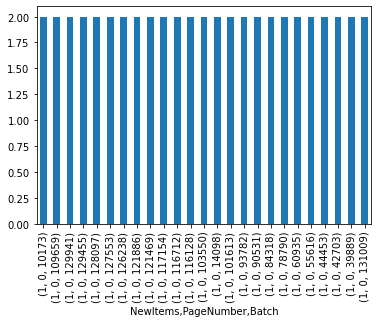

In [40]:

df.head()
testdf = df.drop(columns=["DeltaTime"])
testdf = testdf.loc[df['PageNumber'] %10==0]
testdf = testdf.loc[testdf['NewItems'] == 1]
testdf.head()
testdf.value_counts().plot(x='PageNumber', y='NewItems',kind ='bar')



In [41]:


CATEGORIES = ["Old","New"]
#z = x[y.iloc[0:]==1]
pd.DataFrame(list(zip([0],[416100000000000])))
#print(z.size)
#z.head()

#print(z[z['PageNumber'] == 274])

prediction = model.predict(z)
print(prediction)
print(CATEGORIES[int(prediction[0][0])])

NameError: name 'z' is not defined